In [1]:
# Import dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Set processing unit
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [3]:
# Set seeds of random variables
torch.manual_seed(777)
if device == 'cuda:0':
    torch.cuda.manual_seed_all(777)

In [4]:
# Model training settings
batch_size = 32
n_epochs = 20
lr = 0.001 # learning rate

In [5]:
# Image normalization
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [6]:
# CIFAR10 dataset preparation
train_dataset = datasets.CIFAR10(root='./data/CIFAR10', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data/CIFAR10', train=False, download=True, transform=transform)

# Load CIFAR10 feeder
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


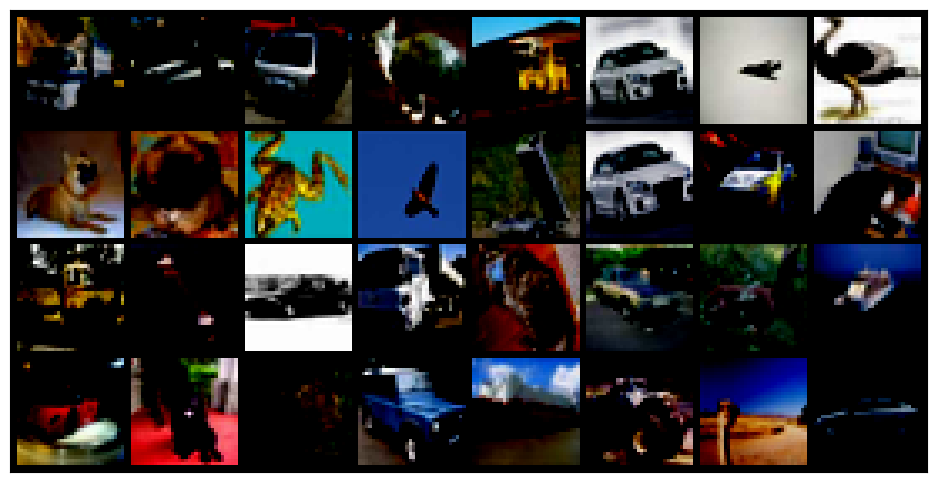

In [7]:
from torchvision.utils import make_grid

for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
    break

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2(output)
        output = self.conv3(output)
        output = self.fc(output)
        return output

In [11]:
# Prepare model training
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [12]:
# Train the model
def train(model, train_loader, optimizer, log_interval=5):
    model.train()
    for idx, (x, y) in tqdm(enumerate(train_loader)):
        x = x.to(device)
        y = y.to(device)
        output = model(x)
        loss = criterion(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (idx + 1) % log_interval == 0:
            print('Train epoch: [{}/{} ({:.2f}%)]\tTrain Loss: {:.6f}'.format(idx * len(x), len(train_loader.dataset), 100. * idx / len(train_loader), loss.item()))

In [13]:
# Evaluate the model
def evaluate(model, test_loader):
    model.eval()
    test_loss = .0
    correct = 0

    with torch.no_grad():
        for x, y in tqdm(test_loader):
            x = x.to(device)
            y = y.to(device)
            output = model(x)
            test_loss += criterion(output, y).item()
            prediction = output.max(1, keepdim=True)[1]
            correct += prediction.eq(y.view_as(prediction)).sum().item()

    test_loss /= len(test_loader.dataset) / batch_size
    accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, accuracy

In [14]:
for epoch in range(n_epochs):
    train(model, train_loader, optimizer, log_interval=10000)
    test_loss, accuracy = evaluate(model, test_loader)
    print("\n[Epoch: {}], \tTest Loss: {:.4f},\tAccuracy: {:.2f} %\n".format(epoch, test_loss, accuracy))

1563it [00:15, 101.46it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 124.63it/s]



[Epoch: 0], 	Test Loss: 1.1992,	Accuracy: 56.73 %



1563it [00:15, 100.27it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 87.27it/s]



[Epoch: 1], 	Test Loss: 0.9364,	Accuracy: 67.32 %



1563it [00:15, 101.52it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 131.32it/s]



[Epoch: 2], 	Test Loss: 0.8244,	Accuracy: 71.41 %



1563it [00:14, 111.04it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 128.89it/s]



[Epoch: 3], 	Test Loss: 0.7725,	Accuracy: 73.06 %



1563it [00:14, 110.45it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 130.72it/s]



[Epoch: 4], 	Test Loss: 0.7767,	Accuracy: 74.42 %



1563it [00:14, 111.12it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.91it/s]



[Epoch: 5], 	Test Loss: 0.7644,	Accuracy: 75.21 %



1563it [00:14, 110.69it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 133.73it/s]



[Epoch: 6], 	Test Loss: 0.7445,	Accuracy: 76.11 %



1563it [00:14, 110.93it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.84it/s]



[Epoch: 7], 	Test Loss: 0.8490,	Accuracy: 75.41 %



1563it [00:14, 106.40it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 127.85it/s]



[Epoch: 8], 	Test Loss: 0.8587,	Accuracy: 76.04 %



1563it [00:14, 105.46it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 127.49it/s]



[Epoch: 9], 	Test Loss: 0.9045,	Accuracy: 76.66 %



1563it [00:14, 105.69it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 128.16it/s]



[Epoch: 10], 	Test Loss: 0.9877,	Accuracy: 75.61 %



1563it [00:14, 105.92it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 127.04it/s]



[Epoch: 11], 	Test Loss: 1.0503,	Accuracy: 74.66 %



1563it [00:14, 108.67it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 133.01it/s]



[Epoch: 12], 	Test Loss: 1.0334,	Accuracy: 75.34 %



1563it [00:14, 108.56it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 133.72it/s]



[Epoch: 13], 	Test Loss: 1.0890,	Accuracy: 75.85 %



1563it [00:14, 109.70it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 127.76it/s]



[Epoch: 14], 	Test Loss: 1.2051,	Accuracy: 74.78 %



1563it [00:14, 107.19it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 131.12it/s]



[Epoch: 15], 	Test Loss: 1.2137,	Accuracy: 75.78 %



1563it [00:14, 109.85it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 130.40it/s]



[Epoch: 16], 	Test Loss: 1.2295,	Accuracy: 76.00 %



1563it [00:14, 104.29it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 117.82it/s]



[Epoch: 17], 	Test Loss: 1.3109,	Accuracy: 76.24 %



1563it [00:15, 100.72it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 124.23it/s]



[Epoch: 18], 	Test Loss: 1.2534,	Accuracy: 75.46 %



1563it [00:15, 102.03it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 119.40it/s]


[Epoch: 19], 	Test Loss: 1.3248,	Accuracy: 75.87 %

